# Предсказание оттока пользователей - конкурс на kaggle.com





### Контест на Kaggle
 [контест на Kaggle](https://www.kaggle.com/c/advanced-dls-spring-2021/)


Данные: [train.csv](https://drive.google.com/file/d/1ERwQ5odiK1Zvi1LtjpkzCMUswYsAX8_K/view?usp=share_link),
[test.csv](https://drive.google.com/file/d/1fGw_-RFwvn_LEdt91Jq-7A-wzG6mmH8r/view?usp=share_link), [submission.csv](https://drive.google.com/file/d/199Mt4OYZNaelT83U-HGDsEYs2YcUGQ6y/view?usp=share_link).

Если ссылки на данные не работают, их можно скачать [на Kaggle](https://www.kaggle.com/competitions/advanced-dls-spring-2021/data).

# Метрика

Перед решением любой задачи важно понимать, как будет оцениваться ваше решение. В данном случае мы используем стандартную для задачи классификации метрику ROC-AUC. Ее можно вычислить, используя только предсказанные вероятности и истинные классы без конкретного порога классификации + она раотает даже если классы в данных сильно несбалансированны (примеров одного класса в десятки раз больше примеров длугого). Именно поэтому она очень удобна для соревнований.

Посчитать ее легко:


In [ ]:
from sklearn.metrics import roc_auc_score

y_true = [
    0,
    1,
    1,
    0,
    1
]

y_predictions = [
    0.1,
    0.9,
    0.4,
    0.6,
    0.61
]

roc_auc_score(y_true, y_predictions)

0.8333333333333333

# Первая часть. Исследование

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

## Загрузка данных (2 балла)

1) Посмотрите на случайные строчки.

2) Посмотрите, есть ли в датасете незаполненные значения (nan'ы) с помощью data.isna() или data.info() и, если нужно, замените их на что-то. Будет хорошо, если вы построите табличку с количеством nan в каждой колонке.

In [ ]:
# !gdown 1ERwQ5odiK1Zvi1LtjpkzCMUswYsAX8_K  # train.csv
# !gdown 1fGw_-RFwvn_LEdt91Jq-7A-wzG6mmH8r  # test.csv
# !gdown 199Mt4OYZNaelT83U-HGDsEYs2YcUGQ6y  # submission.csv

In [ ]:
data = pd.read_csv('./train.csv')
data.head()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.2,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.90,75.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,32,79.30,2570,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0


In [ ]:
# Для вашего удобства списки с именами разных колонок

# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

In [ ]:
# YOUR CODE
# Step 1: Explore the data
print("\nSummary statistics for numerical columns:")
print(data.describe())
print("\nSummary Unique values for numerical columns:")
# Print data types for numerical features
print("\nData types for numerical features:")
for col in num_cols:
    print(f"{col}: {data[col].dtype}")

# Print data types for categorical features
print("\nData types for categorical features:")
for col in cat_cols:
    print(f"{col}: {data[col].dtype}")

print("\nSummary Unique values for categorical columns:")
for col in cat_cols:
    print(f"\nUnique values and counts for {col}:")
    print(data[col].value_counts())


# split types to numerical and cat types
nums = data.select_dtypes(include=['number']).columns
not_nums = data.select_dtypes(include=['object']).columns
print("numerical cols", nums)
print("not numerical cols", not_nums)



Summary statistics for numerical columns:
       ClientPeriod  MonthlySpending  IsSeniorCitizen        Churn
count   5282.000000      5282.000000      5282.000000  5282.000000
mean      32.397009        64.924754         0.159409     0.262022
std       24.550326        30.176464         0.366092     0.439776
min        0.000000        18.250000         0.000000     0.000000
25%        9.000000        35.462500         0.000000     0.000000
50%       29.000000        70.400000         0.000000     0.000000
75%       55.000000        90.050000         0.000000     1.000000
max       72.000000       118.750000         1.000000     1.000000

Summary Unique values for numerical columns:

Data types for numerical features:
ClientPeriod: int64
MonthlySpending: float64
TotalSpent: object

Data types for categorical features:
Sex: object
IsSeniorCitizen: int64
HasPartner: object
HasChild: object
HasPhoneService: object
HasMultiplePhoneNumbers: object
HasInternetService: object
HasOnlineSecurit

**Preprocess**:

IsSeniorCitizen is numerical feature -> move to num_cols

TotalSpent has some empty entries -> convert to nan -> fillin with mean

In [ ]:
# Проверьте наличие NaN-значений в датасете
# Step 2: Check for missing values

# pd.options.mode.use_inf_as_na = True
# pd.set_option('mode.use_inf_as_na', True)
missing_values = data.isna().sum()
print("\nMissing values per column in raw data:")
print(missing_values)

# Convert 'TotalSpent' column to numeric (float) data type
# display(data[pd.to_numeric(data['TotalSpent'], errors='coerce').isna()])

# 'errors='coerce'' will replace any non-numeric values with NaN
data['TotalSpent'] = pd.to_numeric(data['TotalSpent'], errors='coerce')
# Check the data types of the 'TotalSpent' column after conversion
# print(data['TotalSpent'].apply(type))

# Move 'IsSeniorCitizen'  to numeric features
# data['IsSeniorCitizen'].head(20)
# print(data['IsSeniorCitizen'].apply(type))
# if 'IsSeniorCitizen' not in num_cols:
#     num_cols.append('IsSeniorCitizen')
# if 'IsSeniorCitizen' in cat_cols:
#     cat_cols.remove('IsSeniorCitizen')

missing_values = data.isna().sum()
print("\nMissing values per column before fillan:")
print(missing_values)

# Impute missing values in numerical columns with mean
data['TotalSpent'] = data['TotalSpent'].fillna(data['TotalSpent'].mean(skipna=True))

missing_values = data.isna().sum()
print("\nMissing values per column after fillan:")
print(missing_values)


# # Impute missing values in categorical columns with mode
data[cat_cols] = data[cat_cols].fillna(data[cat_cols].mode().iloc[0])



Missing values per column in raw data:
ClientPeriod                0
MonthlySpending             0
TotalSpent                  0
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
Churn                       0
dtype: int64

Missing values per column before fillan:
ClientPeriod                0
MonthlySpending             0
TotalSpent                  9
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOn

## Анализ данных (3 балла)

1) Для численных призанков постройте гистограмму (*plt.hist(...)*) или boxplot (*plt.boxplot(...)*). Для категориальных посчитайте количество каждого значения для каждого признака. Для каждой колонки надо сделать *data.value_counts()* и построить bar диаграммы *plt.bar(...)* или круговые диаграммы *plt.pie(...)* (хорошо, елси вы сможете это сделать на одном гарфике с помощью *plt.subplots(...)*).

2) Посмотрите на распределение целевой переменной и скажите, являются ли классы несбалансированными.


3) (Если будет желание) Поиграйте с разными библиотеками для визуализации - *sns*, *pandas_visual_analysis*, etc.

Второй пункт очень важен, потому что существуют задачи классификации с несбалансированными классами. Например, это может значить, что в датасете намного больше примеров 0 класса. В таких случаях нужно 1) не использовать accuracy как метрику 2) использовать методы борьбы с imbalanced dataset (обычно если датасет сильно несбалансирован, т.е. класса 1 в 20 раз меньше класса 0).

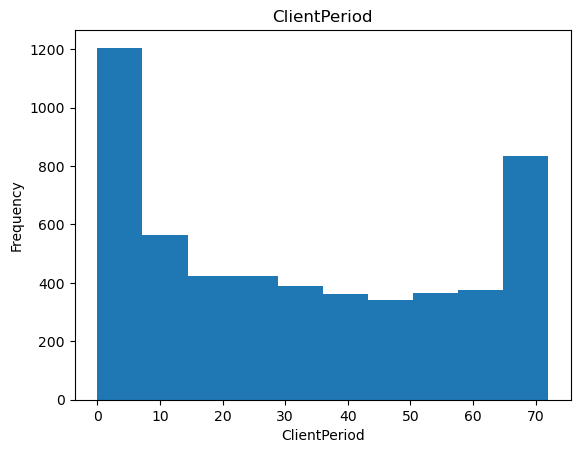

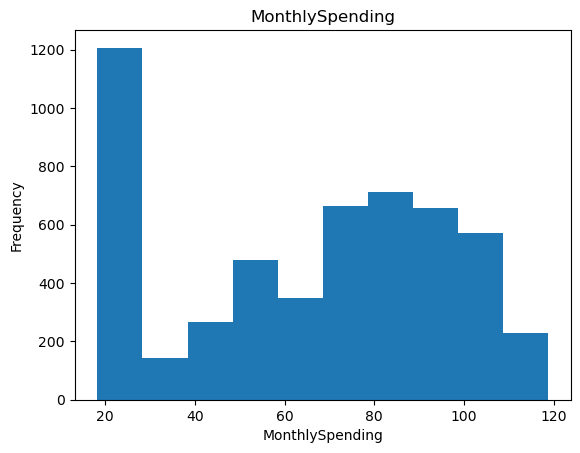

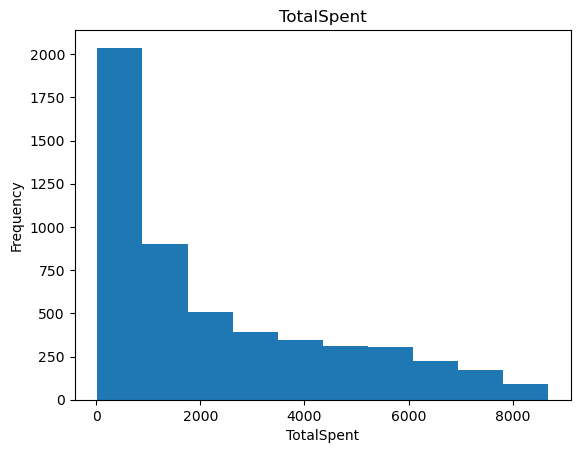

In [ ]:
# YOUR CODE
# гистограммы для численных признаков
for feature in num_cols:
    plt.figure()
    data[feature].plot(kind='hist', title=feature)
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

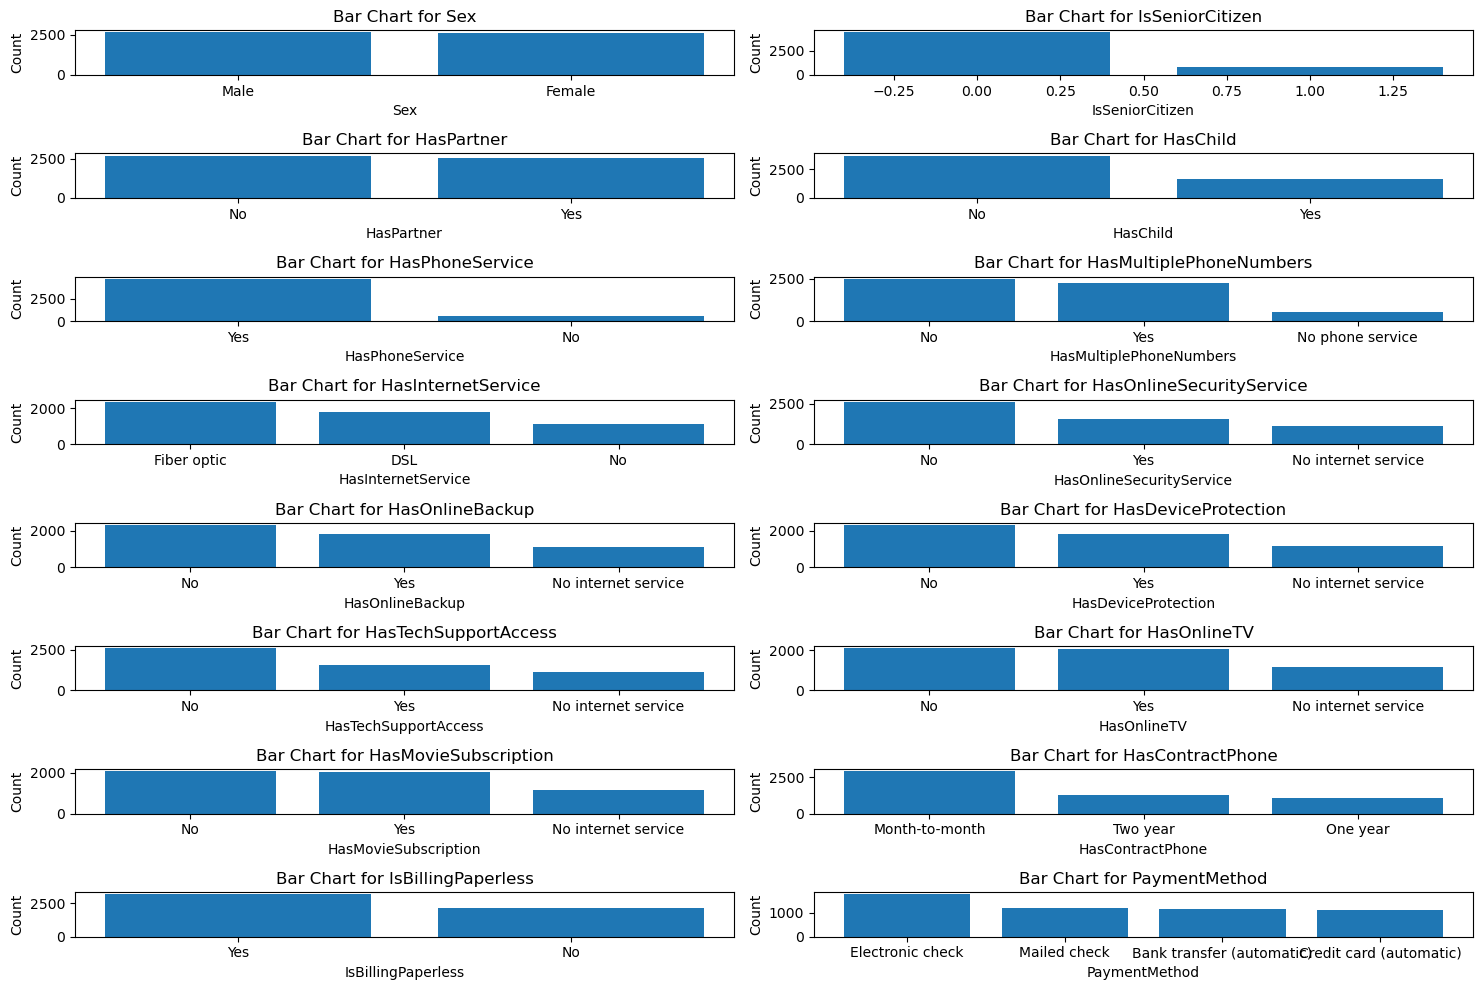

In [ ]:
# YOUR CODE

# Calculate the number of rows and columns for the grid
grid_cols = 2  # Number of columns in the grid
grid_rows = (len(cat_cols) + grid_cols - 1) // grid_cols  # Calculate the number of rows needed

# Create subplots with the specified number of rows and columns
fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(15, 10))

# Flatten the axes array to simplify indexing
axes = axes.flatten()

# Iterate through the categorical columns
for i, col in enumerate(cat_cols):
    value_counts = data[col].value_counts()

    # Create a bar chart
    axes[i].bar(value_counts.index, value_counts)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')
    axes[i].set_title(f'Bar Chart for {col}')


# Remove any empty subplots
for i in range(len(cat_cols), grid_rows * grid_cols):
    fig.delaxes(axes[i])

# Adjust layout to prevent overlapping titles
plt.tight_layout()

# Display the plots
plt.show()



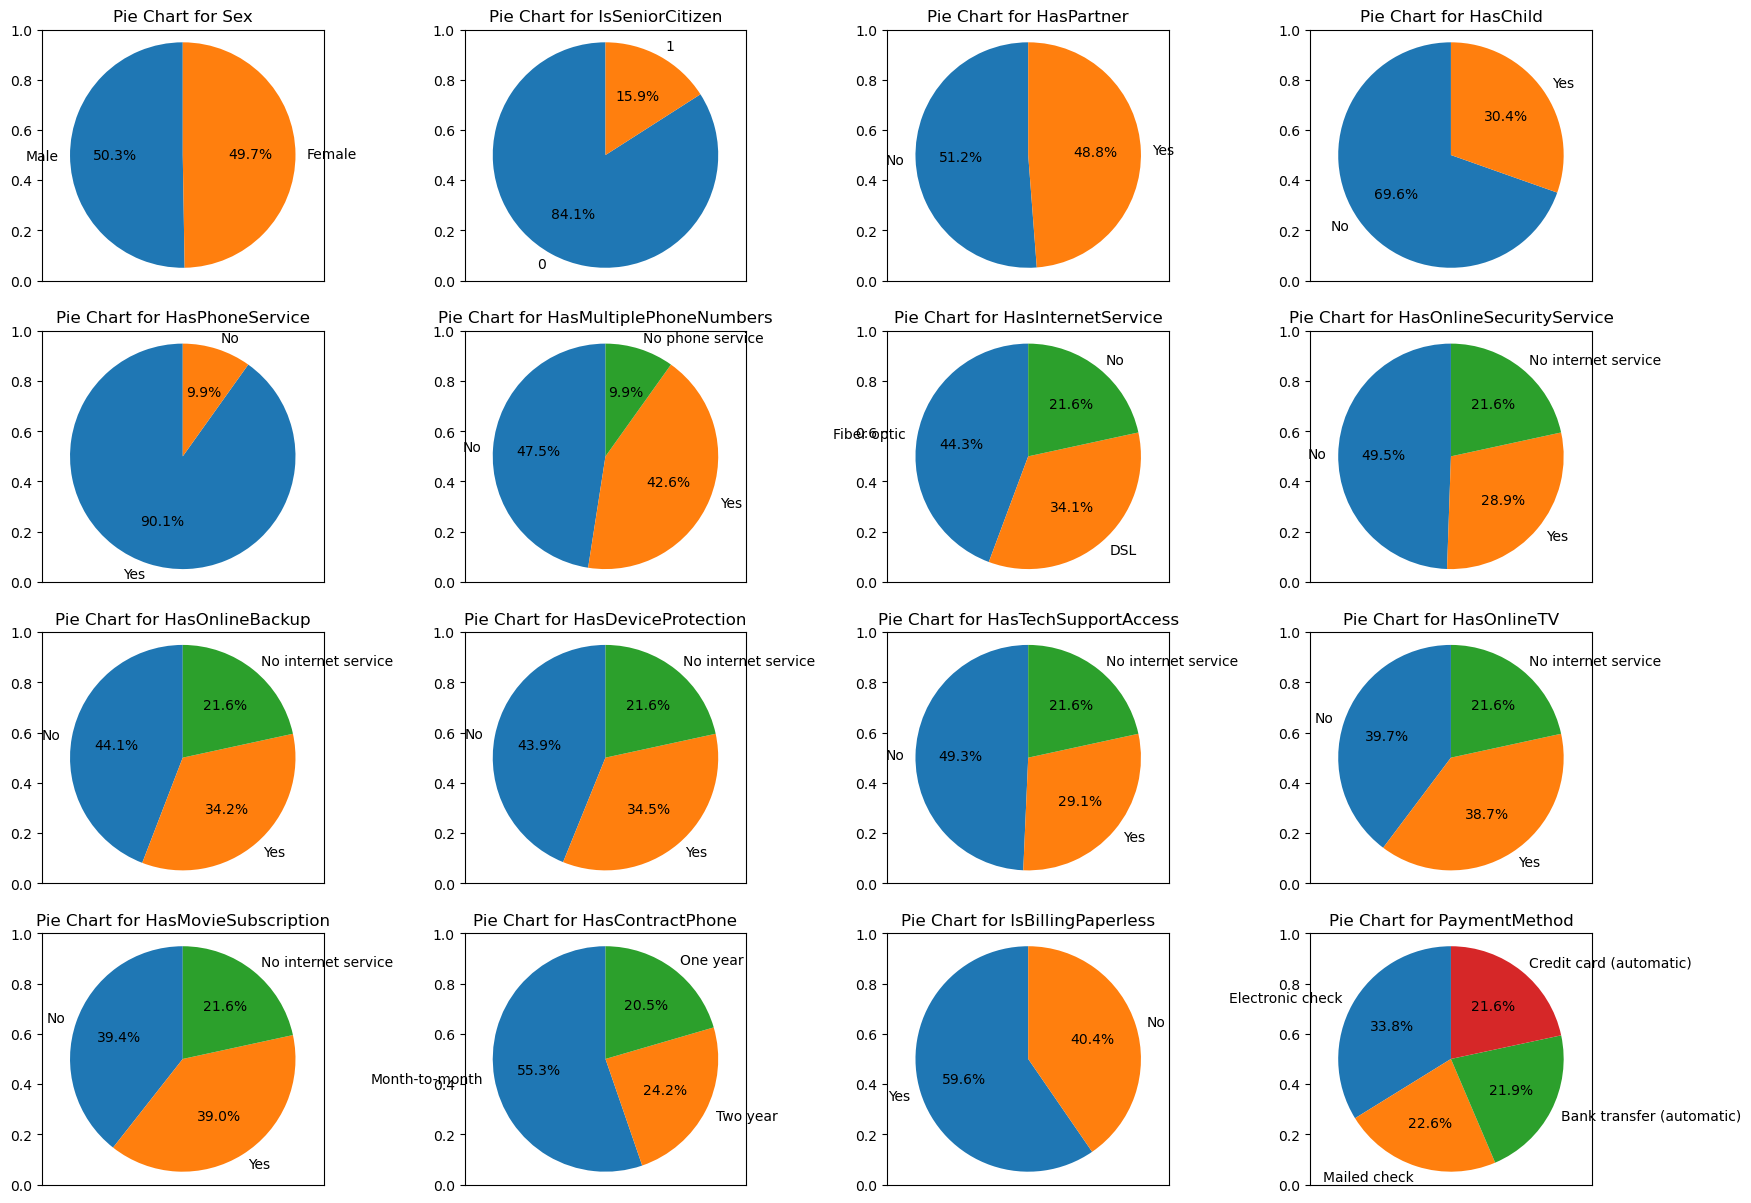

In [ ]:
# YOUR CODE
# Calculate the number of rows and columns for the grid
grid_cols = 4  # Number of columns in the grid (adjust to your preference)
grid_rows = (len(cat_cols) + grid_cols - 1) // grid_cols  # Calculate the number of rows needed

# Create subplots with the specified number of rows and columns
fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(20, 15))  # Adjust the figsize as needed

# Flatten the axes array to simplify indexing
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    value_counts = data[col].value_counts()

    # Create a pie chart as a twin axis
    ax2 = axes[i].twinx()
    ax2.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=90)
    ax2.set_title(f'Pie Chart for {col}')

# Remove any empty subplots
for i in range(len(cat_cols), grid_rows * grid_cols):
    fig.delaxes(axes[i])

# Adjust layout to prevent overlapping titles
plt.subplots_adjust(wspace=0.5)  # Adjust the spacing between subplots

# Display the plots
plt.show()

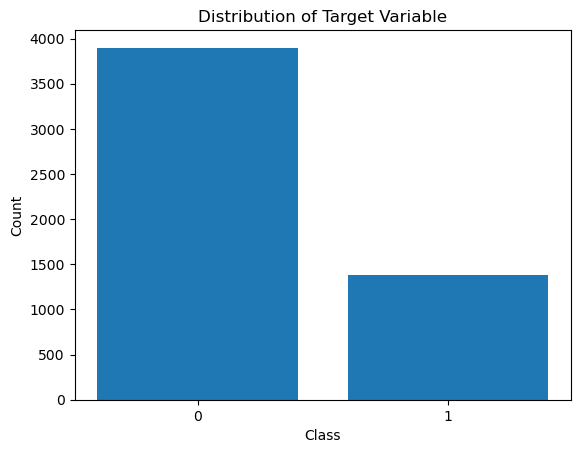

Class Imbalance Ratio: 2.82


In [ ]:
# YOUR CODE
# print(data[target_col].head(5))
class_counts = data[target_col].value_counts()

plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Distribution of Target Variable')
plt.xticks(class_counts.index)  # Ensure all classes are labeled
plt.show()


# unique_values_count = data[target_col].nunique()
# print(f'Number of unique values in the {target_col} column: {unique_values_count}')

imbalance_ratio = class_counts[0] / class_counts[1]  # Assuming class 0 is the majority class
print(f'Class Imbalance Ratio: {imbalance_ratio:.2f}')


(Дополнительно) Если вы нашли какие-то ошибки в данных или выбросы, то можете их убрать. Тут можно поэксперементировать с обработкой данных как угодно, но не за баллы.

## Применение линейных моделей (3 балла)

1) Обработайте данные для того, чтобы к ним можно было применить LogisticRegression. Т.е. отнормируйте числовые признаки, а категориальные закодируйте с помощью one-hot-encoding'а.

2) С помощью кроссвалидации или разделения на train/valid выборку протестируйте разные значения гиперпараметра C и выберите лучший (можно тестировать С=100, 10, 1, 0.1, 0.01, 0.001) по метрике ROC-AUC.

Если вы разделяете на train/valid, то используйте LogisticRegressionCV. Он сам при вызове .fit() подберет параметр С. (не забудьте передать scroing='roc_auc', чтобы при кроссвалидации сравнивались значения этой метрики, и refit=True, чтобы при потом модель обучилась на всем датасете с лучшим параметром C).


(более сложный вариант) Если вы будете использовать кроссвалидацию, то преобразования данных и LogisticRegression нужно соединить в один Pipeline с помощью make_pipeline, как это делалось во втором семинаре. Потом pipeline надо передать в GridSearchCV. Для one-hot-encoding'a можно испльзовать комбинацию LabelEncoder + OneHotEncoder (сначала превращаем строчки в числа, а потом числа првращаем в one-hot вектора.)

ROC-AUC: An Overview

ROC (Receiver Operating Characteristic) curve and AUC (Area Under the Curve) are tools used to evaluate the performance of a binary classification model.

ROC Curve

Definition: The ROC curve is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied.

Axes:

True Positive Rate (TPR): Also known as sensitivity or recall. It is plotted on the Y-axis. TPR = TP / (TP + FN), where TP is true positives and FN is false negatives.

False Positive Rate (FPR): Plotted on the X-axis. FPR = FP / (FP + TN), where FP is false positives and TN is true negatives.

Interpretation: Each point on the ROC curve represents a different threshold. The curve shows the trade-off between sensitivity and specificity.
AUC

Definition: The Area Under the ROC Curve (AUC) quantifies the overall ability of the model to discriminate between positive and negative classes.

Range: AUC ranges from 0 to 1.

AUC = 1: Perfect model.
AUC = 0.5: Model with no discrimination capability (equivalent to random guessing).
AUC < 0.5: Model performing worse than random guessing.

Interpretation: Higher AUC values indicate better model performance. A model with an AUC closer to 1 is considered to have a good measure of separability, meaning it can better distinguish between positive and negative classes.

Importance of ROC-AUC

Threshold Independence: Unlike metrics like accuracy, the ROC-AUC evaluates the model's performance across all possible classification thresholds.

Imbalanced Datasets: Particularly useful for imbalanced datasets where classes are not equally represented. Accuracy can be misleading in such cases, but ROC-AUC provides a more balanced view of performance.

Comparison of Models: ROC-AUC is commonly used to compare the performance of different models. A model with a higher AUC is generally preferred.

In [ ]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline

In [ ]:
# YOUR CODE
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


display(data.head(5))
# Remove the target column from the data DataFrame
# X = data.drop(columns=[target_col])
# display(X.head())

# Calculate mean and std before normalization
mean_before = data[num_cols].mean()
std_before = data[num_cols].std()
# Display mean and std before and after transformation
print("Mean and Standard Deviation Before Normalization:")
print(mean_before)
print(std_before)

# Create a ColumnTransformer to apply StandardScaler only to numerical columns
print(num_cols)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols)
    ],
    remainder='passthrough'  # Keeps other columns as they are
)


# Fit and transform the data using the preprocessor
data_normalized_array = preprocessor.fit_transform(data)
# Convert the NumPy array back to a pandas DataFrame
data_normalized = pd.DataFrame(data_normalized_array, columns = data.columns)
display(data_normalized.head(5))
# data_normalized.to_csv('output.csv')

# Calculate mean and standard deviation after normalization for num_cols
# Create a list to store the means of each numerical column
print("Mean and Standard Deviation After Normalization:")
# print(num_cols)
# for col in num_cols:
#     print(f"{col}: {data[col].dtype}")

mean_after = data_normalized[num_cols].mean()
std_after = data_normalized[num_cols].std()
print(mean_after)
print(std_after)


,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.20,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.90,75.90,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,32,79.30,2570.00,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0


Mean and Standard Deviation Before Normalization:
ClientPeriod         32.397009
MonthlySpending      64.924754
TotalSpent         2291.390461
dtype: float64
ClientPeriod         24.550326
MonthlySpending      30.176464
TotalSpent         2267.079956
dtype: float64
['ClientPeriod', 'MonthlySpending', 'TotalSpent']


,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,0.920767,-1.505447,-0.558057,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,1.613288,-1.294998,-0.184921,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,-1.279005,0.363737,-0.977337,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,-0.016173,0.476418,0.122905,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,1.12445,1.667856,1.970589,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0


Mean and Standard Deviation After Normalization:
ClientPeriod      -0.0
MonthlySpending   -0.0
TotalSpent        -0.0
dtype: object
ClientPeriod       1.000095
MonthlySpending    1.000095
TotalSpent         1.000095
dtype: object


In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# Define the feature data (X) and target variable (y)
X = data.drop(columns=[target_col])
y = data[target_col]

# Create a preprocessing pipeline for numerical features
numerical_pipeline = make_pipeline(
    StandardScaler()
)

# Create a preprocessing pipeline for categorical features
categorical_pipeline = make_pipeline(
#     LabelEncoder(),
    OneHotEncoder()
)

# Combine numerical and categorical pipelines using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, num_cols),
        ('cat', categorical_pipeline, cat_cols)
    ],
    remainder='drop'  # You can choose how to handle any remaining columns
)

# Create a pipeline for logistic regression, including preprocessing and modeling
logistic_pipeline = make_pipeline(
    preprocessor,
    LogisticRegression(max_iter=10000)
)

# Fit the pipeline to your data
logistic_pipeline.fit(X, y)

# Predict the target variable
y_pred = logistic_pipeline.predict(X)

# Calculate the ROC-AUC score
roc_auc = roc_auc_score(y, y_pred)

print(f"ROC-AUC Score: {roc_auc}")

ROC-AUC Score: 0.7207998321356438


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# Define the feature data (X) and target variable (y)
X = data.drop(columns=[target_col])
y = data[target_col]
display(X.head(5))
display(y.head(5))

# Create a preprocessing pipeline for numerical features
numerical_pipeline = make_pipeline(
    StandardScaler()
)

# Create a preprocessing pipeline for categorical features
categorical_pipeline = make_pipeline(
#     LabelEncoder(),
    OneHotEncoder()
)

# Combine numerical and categorical pipelines using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, num_cols),
        ('cat', categorical_pipeline, cat_cols)
    ],
    remainder='drop'  # You can choose how to handle any remaining columns
)

# Create a pipeline for logistic regression, including preprocessing and modeling
logistic_pipeline = make_pipeline(
    preprocessor,
    LogisticRegression(max_iter=10000)
)

# Define hyperparameters to search through in GridSearchCV
# TBD visualization
param_grid = {
    'logisticregression__C': [100, 10, 1, 0.1, 0.01, 0.001],
}

# Create a GridSearchCV object
grid_search = GridSearchCV(logistic_pipeline, param_grid, cv=5, scoring='roc_auc')

# Fit the grid search to your data
grid_search.fit(X, y)

best_C = grid_search.best_params_['logisticregression__C']

# Get the ROC-AUC score for the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X)
roc_auc = roc_auc_score(y, y_pred)

print(f"Best C: {best_C}")
print(f"ROC-AUC Score: {roc_auc}")


,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check
1,72,25.85,1872.20,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic)
2,1,75.90,75.90,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check
3,32,79.30,2570.00,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic)


0    0
1    0
2    1
3    0
4    0
Name: Churn, dtype: int64

Best C: 100
ROC-AUC Score: 0.7240748182705227


Выпишите какое лучшее качество и с какими параметрами вам удалось получить

## Применение градиентного бустинга (2 балла)

Если вы хотите получить баллы за точный ответ, то стоит попробовать градиентный бустинг. Часто градиентный бустинг с параметрами по умолчанию даст вам 80% результата за 0% усилий.

Мы будем использовать catboost, поэтому нам не надо кодировать категориальные признаки. Catboost сделает это сам (в .fit() надо передать cat_features=cat_cols). А численные признаки нормировать для моделей, основанных на деревьях не нужно.

1) Разделите выборку на train/valid. Протестируйте catboost cо стандартными параметрами.

2) Протестируйте разные занчения параметроа количества деревьев и learning_rate'а и выберите лучшую по метрике ROC-AUC комбинацию.

(Дополнительно) Есть некоторые сложности с тем, чтобы использовать CatBoostClassifier вместе с GridSearchCV, поэтому мы не просим использовать кроссвалидацию. Но можете попробовать)

In [ ]:
# YOUR CODE
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score


# Define the feature data (X) and target variable (y)
X = data.drop(columns=[target_col])
y = data[target_col]

# Split the dataset into train and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=12)

# Create a CatBoost dataset for training and validation
train_dataset = Pool(data=X_train, label=y_train, cat_features=cat_cols)
valid_dataset = Pool(data=X_valid, label=y_valid, cat_features=cat_cols)

# Initialize the CatBoostClassifier with default parameters
model = CatBoostClassifier(iterations=500, learning_rate=0.1, depth=6, loss_function='Logloss', custom_metric='AUC', verbose=100)

# Fit the model to the training data
model.fit(train_dataset, eval_set=valid_dataset, use_best_model=True)

# Predict on the validation set
y_pred = model.predict(valid_dataset, prediction_type='Probability')[:, 1]

# Calculate ROC-AUC score
roc_auc = roc_auc_score(y_valid, y_pred)
print(f"ROC-AUC Score: {roc_auc}")



0:	learn: 0.6305428	test: 0.6292392	best: 0.6292392 (0)	total: 6.5ms	remaining: 3.24s
100:	learn: 0.3764778	test: 0.3929992	best: 0.3915080 (81)	total: 467ms	remaining: 1.84s
200:	learn: 0.3332754	test: 0.3947038	best: 0.3915080 (81)	total: 980ms	remaining: 1.46s
300:	learn: 0.2977125	test: 0.4015322	best: 0.3915080 (81)	total: 1.51s	remaining: 998ms
400:	learn: 0.2679897	test: 0.4110117	best: 0.3915080 (81)	total: 2.06s	remaining: 507ms
499:	learn: 0.2436868	test: 0.4161686	best: 0.3915080 (81)	total: 2.56s	remaining: 0us

bestTest = 0.3915079696
bestIteration = 81

Shrink model to first 82 iterations.
ROC-AUC Score: 0.8637316903045804


Выпишите, какое лучшее качество и с какими параметрами вам удалось получить

0.863


# Предсказания

In [ ]:
best_model = model

In [ ]:
X_test = pd.read_csv('./test.csv')
submission = pd.read_csv('./submission.csv')
display(submission)

submission['Churn'] = best_model.predict_proba(X_test) [:, 1]
# submission['Churn'] =  best_model.predict(X_test)
display(submission)
submission.to_csv('my_submission1.csv')

,Id,Churn
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5
...,...,...
1756,1756,0.5
1757,1757,0.5
1758,1758,0.5
1759,1759,0.5


,Id,Churn
0,0,0.054298
1,1,0.644984
2,2,0.697224
3,3,0.016483
4,4,0.005272
...,...,...
1756,1756,0.148376
1757,1757,0.016783
1758,1758,0.842260
1759,1759,0.610946
